_ColormakerRegistry()

[utils.py:141 - _init_num_threads()] NumExpr defaulting to 8 threads.
[tautomers.py:48 - __init__()] Nr of conformations generated per tautomer: 2
[tautomers.py:49 - __init__()] Chirality enforced: True
[tautomers.py:431 - _perform_tautomer_transformation()] Index of atom that moves: 11.
[tautomers.py:443 - _perform_tautomer_transformation()] Index of atom that donates hydrogen: 0
[tautomers.py:461 - _perform_tautomer_transformation()] Index of atom that accepts hydrogen: 10


SAMPLmol2


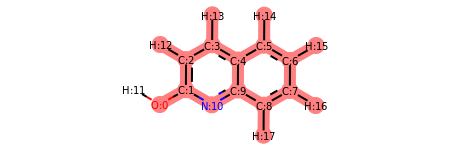

TypeError: __init__() missing 2 required positional arguments: 'adventure_mode' and 'per_atom_thresh'

In [1]:
import neutromeratio
from openmmtools.constants import kB
from simtk import unit
import numpy as np
import pickle
import mdtraj as md
import matplotlib.pyplot as plt
import sys
import torch
from neutromeratio.parameter_gradients import FreeEnergyCalculator
from neutromeratio.constants import kT, device, exclude_set
from glob import glob

def parse_lambda_from_dcd_filename(dcd_filename, env):
    return float(dcd_filename[:dcd_filename.find(f"_in_{env}")].split('_')[-1])

# where to write the results
base_path = '/home/mwieder/tmp_wd/'
env = 'droplet'
per_atom_stddev_threshold = 0.5 # in kJ/mol
diameter_in_angstrom = 18


thinning = 5
#######################
#######################
mode = 'forward'

# read in exp results, smiles and names
exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))

name = 'SAMPLmol2'
print(name)

# don't change - direction is fixed for all runs
#################
t1_smiles = exp_results[name]['t1-smiles']
t2_smiles = exp_results[name]['t2-smiles']


# generate both rdkit mol
tautomer = neutromeratio.Tautomer(name=name, 
                                initial_state_mol=neutromeratio.generate_rdkit_mol(t1_smiles), 
                                final_state_mol=neutromeratio.generate_rdkit_mol(t2_smiles), 
                                nr_of_conformations=2)
if mode == 'forward':
    tautomer.perform_tautomer_transformation_forward()
elif mode == 'reverse':
    tautomer.perform_tautomer_transformation_reverse()
else:
    raise RuntimeError('No tautomer reaction direction was specified.')

if env == 'droplet':
    tautomer.add_droplet(tautomer.hybrid_topology, 
                                tautomer.hybrid_coords, 
                                diameter=diameter_in_angstrom * unit.angstrom,
                                restrain_hydrogens=True,
                                file=f"{base_path}/{name}/{name}_in_droplet_{mode}.pdb")

    print('Nr of atoms: {}'.format(len(tautomer.ligand_in_water_atoms)))
    atoms = tautomer.ligand_in_water_atoms
    top = tautomer.ligand_in_water_topology
else:
    atoms = tautomer.hybrid_atoms
    top = tautomer.hybrid_topology

# define the alchemical atoms
alchemical_atoms=[tautomer.hybrid_hydrogen_idx_at_lambda_1, tautomer.hybrid_hydrogen_idx_at_lambda_0]


# extract hydrogen donor idx and hydrogen idx for from_mol
model = neutromeratio.ani.LinearAlchemicalDualTopologyANI(alchemical_atoms=alchemical_atoms)

model = model.to(device)
torch.set_num_threads(2)

# perform initial sampling
energy_function = neutromeratio.ANI1_force_and_energy(
                                        model = model,
                                        atoms = atoms,
                                        mol = None,
                                        adventure_mode=True,
                                        per_atom_thresh=0.5 * unit.kilojoule_per_mole
                                        )


for r in tautomer.ligand_restraints:
    energy_function.add_restraint(r)
for r in tautomer.hybrid_ligand_restraints:
    energy_function.add_restraint(r)

if env == 'droplet':
    tautomer.add_COM_for_hybrid_ligand(np.array([diameter_in_angstrom/2, diameter_in_angstrom/2, diameter_in_angstrom/2]) * unit.angstrom)
    for r in tautomer.solvent_restraints:
        energy_function.add_restraint(r)
    for r in tautomer.com_restraints:
        energy_function.add_restraint(r)

# get steps inclusive endpoints
# and lambda values in list
dcds = glob(f"{base_path}/{name}/*.dcd")

lambdas = []
ani_trajs = []
energies = []

for dcd_filename in dcds:
    lam = parse_lambda_from_dcd_filename(dcd_filename, env)
    lambdas.append(lam)
    traj = md.load_dcd(dcd_filename, top=top)[::thinning]
    print(f"Nr of frames in trajectory: {len(traj)}")
    ani_trajs.append(traj)  
    f = open(f"{base_path}/{name}/{name}_lambda_{lam:0.4f}_energy_in_{env}_{mode}.csv", 'r')  
    energies.append(np.array([float(e) for e in f][::thinning]))
    f.close()

# plotting the energies for all equilibrium runs
for e in energies: 
    plt.plot(e, alpha=0.5)
plt.show()
plt.savefig(f"{base_path}/{name}/{name}_energy.png")

# calculate free energy in kT
fec_filtered = FreeEnergyCalculator(ani_model=energy_function, 
                            ani_trajs=ani_trajs, 
                            potential_energy_trajs=energies, 
                            lambdas=lambdas,
                            n_atoms=len(atoms),
                            max_snapshots_per_window=30,
                            per_atom_thresh=per_atom_stddev_threshold * unit.kilojoule_per_mole)

DeltaF_ji, dDeltaF_ji = fec_filtered.end_state_free_energy_difference
print(fec_filtered.end_state_free_energy_difference)


In [ ]:
import neutromeratio
from openmmtools.constants import kB
from simtk import unit
import numpy as np
import pickle
import mdtraj as md
import matplotlib.pyplot as plt
import sys
import torch
from neutromeratio.parameter_gradients import FreeEnergyCalculator
from neutromeratio.constants import kT, device, exclude_set
from glob import glob

def parse_lambda_from_dcd_filename(dcd_filename, env):
    return float(dcd_filename[:dcd_filename.find(f"_in_{env}")].split('_')[-1])

# where to write the results
base_path = '/home/mwieder/tmp_wd/'
env = 'droplet'
per_atom_stddev_threshold = 100.5 # in kJ/mol
diameter_in_angstrom = 18


thinning = 5
#######################
#######################
mode = 'forward'

# read in exp results, smiles and names
exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))

name = 'SAMPLmol2'
print(name)

# don't change - direction is fixed for all runs
#################
t1_smiles = exp_results[name]['t1-smiles']
t2_smiles = exp_results[name]['t2-smiles']


# generate both rdkit mol
tautomer = neutromeratio.Tautomer(name=name, 
                                initial_state_mol=neutromeratio.generate_rdkit_mol(t1_smiles), 
                                final_state_mol=neutromeratio.generate_rdkit_mol(t2_smiles), 
                                nr_of_conformations=2)
if mode == 'forward':
    tautomer.perform_tautomer_transformation_forward()
elif mode == 'reverse':
    tautomer.perform_tautomer_transformation_reverse()
else:
    raise RuntimeError('No tautomer reaction direction was specified.')

if env == 'droplet':
    tautomer.add_droplet(tautomer.hybrid_topology, 
                                tautomer.hybrid_coords, 
                                diameter=diameter_in_angstrom * unit.angstrom,
                                restrain_hydrogens=True,
                                file=f"{base_path}/{name}/{name}_in_droplet_{mode}.pdb")

    print('Nr of atoms: {}'.format(len(tautomer.ligand_in_water_atoms)))
    atoms = tautomer.ligand_in_water_atoms
    top = tautomer.ligand_in_water_topology
else:
    atoms = tautomer.hybrid_atoms
    top = tautomer.hybrid_topology

# define the alchemical atoms
alchemical_atoms=[tautomer.hybrid_hydrogen_idx_at_lambda_1, tautomer.hybrid_hydrogen_idx_at_lambda_0]


# extract hydrogen donor idx and hydrogen idx for from_mol
model = neutromeratio.ani.LinearAlchemicalDualTopologyANI(alchemical_atoms=alchemical_atoms, 
                                                        adventure_mode=True,
                                                        per_atom_thresh=0.5 * unit.kilojoule_per_mole
                                                        )

model = model.to(device)
torch.set_num_threads(2)

# perform initial sampling
energy_function = neutromeratio.ANI1_force_and_energy(
                                        model = model,
                                        atoms = atoms,
                                        mol = None,
                                        )


for r in tautomer.ligand_restraints:
    energy_function.add_restraint(r)
for r in tautomer.hybrid_ligand_restraints:
    energy_function.add_restraint(r)

if env == 'droplet':
    tautomer.add_COM_for_hybrid_ligand(np.array([diameter_in_angstrom/2, diameter_in_angstrom/2, diameter_in_angstrom/2]) * unit.angstrom)
    for r in tautomer.solvent_restraints:
        energy_function.add_restraint(r)
    for r in tautomer.com_restraints:
        energy_function.add_restraint(r)

# get steps inclusive endpoints
# and lambda values in list
dcds = glob(f"{base_path}/{name}/*.dcd")

lambdas = []
ani_trajs = []
energies = []

for dcd_filename in dcds:
    lam = parse_lambda_from_dcd_filename(dcd_filename, env)
    lambdas.append(lam)
    traj = md.load_dcd(dcd_filename, top=top)[::thinning]
    print(f"Nr of frames in trajectory: {len(traj)}")
    ani_trajs.append(traj)  
    f = open(f"{base_path}/{name}/{name}_lambda_{lam:0.4f}_energy_in_{env}_{mode}.csv", 'r')  
    energies.append(np.array([float(e) for e in f][::thinning]))
    f.close()

# plotting the energies for all equilibrium runs
for e in energies: 
    plt.plot(e, alpha=0.5)
plt.show()
plt.savefig(f"{base_path}/{name}/{name}_energy.png")

# calculate free energy in kT
fec_unfiltered = FreeEnergyCalculator(ani_model=energy_function, 
                            ani_trajs=ani_trajs, 
                            potential_energy_trajs=energies, 
                            lambdas=lambdas,
                            n_atoms=len(atoms),
                            max_snapshots_per_window=30,
                            per_atom_thresh=per_atom_stddev_threshold * unit.kilojoule_per_mole)

DeltaF_ji, dDeltaF_ji = fec_unfiltered.end_state_free_energy_difference
print(fec_unfiltered.end_state_free_energy_difference)


In [ ]:
mbar_unfiltered = fec_unfiltered.mbar
mbar_filtered = fec_filtered.mbar

In [ ]:
plt.figure(figsize=[8,8], dpi=300)
plt.imshow(mbar_unfiltered.computeOverlap()[-1], cmap='Blues')
plt.title('Overlap for unfiltered mbar results for SAMPL2_mol2', fontsize=15)
plt.xlabel('lambda state (0 to 1)', fontsize=15)
plt.ylabel('lambda state (0 to 1)', fontsize=15)
plt.legend()
plt.colorbar()
plt.show()



In [ ]:
x = [a for a in range(1, len(mbar_unfiltered.getFreeEnergyDifferences()[0])+1)]
y = list(mbar_unfiltered.getFreeEnergyDifferences()[0][0])
y_error = mbar_unfiltered.getFreeEnergyDifferences()[1][0]
plt.errorbar(x, y, yerr=y_error, label='ddG +- stddev [kT]')
plt.title('Free energy estimate unfiltered mbar results', fontsize=15)
plt.ylabel('Free energy estimate in kT')
plt.xlabel('lambda state (0 to 1)', fontsize=15)       
plt.show()
plt.close()    


In [ ]:
plt.figure(figsize=[8,8], dpi=300)
plt.imshow(mbar_filtered.computeOverlap()[-1], cmap='Blues')
plt.title('Overlap for filtered mbar results for SAMPL2_mol2', fontsize=15)
plt.xlabel('lambda state (0 to 1)', fontsize=15)
plt.ylabel('lambda state (0 to 1)', fontsize=15)
plt.legend()
plt.colorbar()
plt.show()



In [ ]:
x = [a for a in range(1, len(mbar_filtered.getFreeEnergyDifferences()[0])+1)]
y = list(mbar_filtered.getFreeEnergyDifferences()[0][0])
y_error = mbar_filtered.getFreeEnergyDifferences()[1][0]
plt.errorbar(x, y, yerr=y_error, label='ddG +- stddev [kT]')
plt.title('Free energy estimate filtered mbar results', fontsize=15)
plt.ylabel('Free energy estimate in kT')
plt.xlabel('lambda state (0 to 1)', fontsize=15)       
plt.show()
plt.close()    


In [ ]:
plt.figure(figsize=[8,8], dpi=300)
plt.imshow(mbar_filtered.getWeights().T, cmap='Blues', aspect='auto')
plt.title('weigthts for filtered confs')
plt.xlabel('confs')
plt.ylabel('lambda')
plt.show()

In [ ]:
plt.figure(figsize=[8,8], dpi=300)
plt.imshow(mbar_unfiltered.getWeights().T, cmap='Blues', aspect='auto')
plt.title('weights unfiltered confs')
plt.xlabel('confs')
plt.ylabel('lambda')
plt.show()

In [ ]:
plt.figure(figsize=[8,8], dpi=300)
plt.imshow(mbar_unfiltered.u_kn, cmap='Blues')
plt.show()

In [ ]:
plt.figure(figsize=[8,8], dpi=300)
lam = 5
plt.plot(mbar_unfiltered.u_kn[lam] - min(mbar_unfiltered.u_kn[lam]), label='unfiltered')
plt.title('Plotting mbar u_kn[0]')
plt.ylabel('energy [kT]')
plt.xlabel('conformations')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=[20,20], dpi=300)
plt.imshow(mbar_filtered.u_kn, cmap='Blues')
plt.show()

In [ ]:
plt.figure(figsize=[8,8], dpi=300)
lam = 1
#plt.plot(np.exp(mbar_filtered.getWeights().T[0]))
plt.plot(mbar_unfiltered.u_kn[lam] - min(mbar_filtered.u_kn[lam]), label='unfiltered')
plt.plot(mbar_filtered.u_kn[lam] - min(mbar_filtered.u_kn[lam]), label='filtered')
plt.title('Plotting mbar u_kn[0]')
plt.ylabel('energy [kT]')
plt.xlabel('conformations')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=[20,20], dpi=300)

cutoff = -1
lam=0
r = (mbar_unfiltered.u_kn[lam] - min(mbar_unfiltered.u_kn[lam]))[:cutoff]
w = mbar_unfiltered.getWeights().T[lam][:cutoff]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('snapshot')
ax1.set_ylabel('unfiltered energy', color=color)
ax1.plot(r, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('ensemble weight', color=color)  # we already handled the x-label with ax1
ax2.plot(w, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.xlabel('confs')
plt.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [ ]:
np.sum(mbar_unfiltered.getWeights()[20])

In [ ]:
plt.plot(mbar_filtered.getWeights().T[0])

In [ ]:
plt.plot()